In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats.meta_analysis import effectsize_smd
from statsmodels.stats import proportion
from statsmodels.stats.power import tt_ind_solve_power

%matplotlib inline
plt.style.use('ggplot')

### Изучим состав данных

In [91]:
dataset = pd.read_excel("AB_Test_Results (2).xlsx")
dataset.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [92]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [93]:
dataset.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

<p>Нет пропущенных значений в датасете</p>

In [94]:
dataset.shape

(10000, 3)

In [95]:
dataset.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


<p>Проверим на наличие дублей</p>

In [96]:
df = dataset.groupby(['USER_ID','VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,3,control,0.0
2,3,variant,0.0
3,4,variant,0.0
4,5,variant,0.0


In [111]:
df1 = df.groupby(['USER_ID'], as_index=False).agg({'VARIANT_NAME': 'count'})#группируем выручку по пользователям
df1.VARIANT_NAME.value_counts()#сколько пользователей попали в таблицу больше 1 раза

1    4783
2    1541
Name: VARIANT_NAME, dtype: int64

<p>Найдены 1541 пользователей, отнесенных в обе группы - тестовую и контрольную. Эти данные удалим из исходного датасета как некорректные</p>

In [112]:
del_users = df1.USER_ID[df1['VARIANT_NAME']>1] #список дублированных пользователей

In [115]:
df_clean = df[~df['USER_ID'].isin(del_users)]#удаляем дубли
df_clean

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
3,4,variant,0.0
4,5,variant,0.0
5,6,variant,0.0
6,9,variant,0.0
...,...,...,...
7856,9990,variant,0.0
7857,9992,control,0.0
7858,9993,control,0.0
7859,9995,variant,0.0


In [116]:
df_clean.VARIANT_NAME.value_counts()

variant    2393
control    2390
Name: VARIANT_NAME, dtype: int64

<p>Спилит по пользователям сделан хорошо, разница между количественным составом незначительна</p>

In [118]:
df_clean[df_clean["REVENUE"]>0]

,USER_ID,VARIANT_NAME,REVENUE
37,56,variant,2.99
89,124,control,1.25
125,169,control,4.33
211,282,control,18.56
345,443,variant,3.75
...,...,...,...
7338,9317,variant,2.27
7481,9491,control,2.34
7501,9520,variant,5.08
7693,9766,control,3.79


#### Посмотрим на тестовую и контрольную группы отдельно

In [124]:
ctrl = df_clean[df_clean["VARIANT_NAME"]=="control"].copy(deep=True)
vrnt = df_clean[df_clean["VARIANT_NAME"]=="variant"].copy(deep=True)

In [125]:
ctrl.describe()

,USER_ID,REVENUE
count,2390.000000,2390.000000
mean,5020.881590,0.196887
std,2904.850992,4.172201
min,2.000000,0.000000
25%,2517.250000,0.000000
50%,5012.500000,0.000000
75%,7616.000000,0.000000
max,9998.000000,196.010000


In [126]:
ctrl.value_counts()

USER_ID  VARIANT_NAME  REVENUE
9998     control       0.0        1
3324     control       0.0        1
3316     control       0.0        1
3313     control       0.0        1
3309     control       0.0        1
                                 ..
6777     control       0.0        1
6770     control       0.0        1
6767     control       0.0        1
6758     control       0.0        1
2        control       0.0        1
Length: 2390, dtype: int64

### Расчитаем разницу между группами

In [ ]:
# зафиксируем значения ошибок 1-ого и 2-ого рода
a = 0.05
b = 0.2

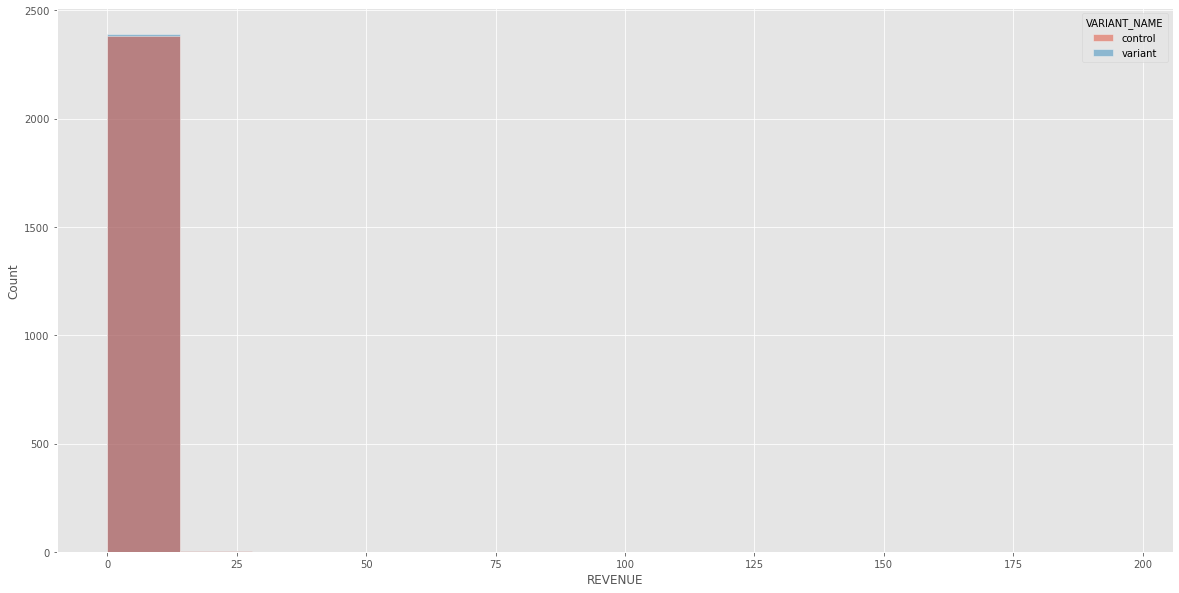

In [138]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.histplot(data=df_clean, x='REVENUE', hue='VARIANT_NAME')
plt.show()

<p>Визуально значительной разницы в распределении нет</p>

In [18]:
def continious_result(control: pd.DataFrame,
                      treatment: pd.DataFrame,
                      column: str,
                      n_iters: int = 10_000) -> pd.DataFrame:
    # Статистика по выборкам
    size = control.loc[:, column].shape[0]
    
    control_mean = control.loc[:, column].mean()
    treatment_mean = treatment.loc[:, column].mean()
    
    control_std = control.loc[:, column].std(ddof=1)
    treatment_std = treatment.loc[:, column].std(ddof=1)
    
    # Бутсрап
    booted_diff = []
    for _ in range(n_iters):
        control_sample = control.loc[:, column].sample(n=size, replace=True).values
        treatment_sample = treatment.loc[:, column].sample(n=size, replace=True).values
        booted_diff.append(np.mean(control_sample - treatment_sample))
    
    # Считаем статистику после бустрапа
    md_ci, std_ci = np.mean(booted_diff), np.std(booted_diff, ddof=1)
    left_ci, right_ci = np.percentile(booted_diff, [2.5, 97.5])
    p_value_ci = 2 * (1 - stats.norm.cdf(np.abs(md_ci / std_ci)))
    
    # Считаем мощность эксперимента
    effect_size, _ = effectsize_smd(mean1=treatment_mean, sd1=treatment_std, nobs1=size,
                                    mean2=control_mean, sd2=control_std, nobs2=size)
    power = tt_ind_solve_power(effect_size=effect_size,
                               nobs1=size,
                               alpha=.05,
                               power=None,
                               ratio=1)
    # Формируем отчёт 
    result = pd.DataFrame({'effect_size': effect_size,
                           'alpha': p_value_ci, 
                           'beta': (1-power),
                           'CI': f'[{np.round(left_ci, 3)}, {np.round(right_ci, 3)}]',
                           'difference': md_ci,},
                          index=[column]) 
    return result

In [130]:
continious_result(ctrl, vrnt, "REVENUE")

,effect_size,alpha,beta,CI,difference
REVENUE,-0.040483,0.165799,0.712143,"[-0.005, 0.321]",0.121047


### Вывод:

<p>Т.к. a=0.166 превышает принятое значение 0.05, b = 0.71 превышает принятое значение 0.2, а доверительный интервал включает в себя 0, то гипотезу о наличии статистически значимых различий отвергаем. Протестированные изменения не стоит принимать для всех пользователей</p>